# Text to Text Explanation: Open Ended Text Generation Using GPT2

This notebook demonstrates how to get explanations for the output of gpt2 used for open ended text generation. In this demo, we use the pretrained gpt2 model provided by hugging face (https://huggingface.co/gpt2) to explain the generated text by gpt2. We further showcase how to get explanations for custom output generated text and plot global input token importances for any output generated token.

In [1]:
!conda list

# packages in environment at C:\Users\v-maxtell\Miniconda3\envs\interpret_cpu:
#
# Name                    Version                   Build  Channel
_py-xgboost-mutex         2.0                       cpu_0  
absl-py                   0.11.0             pyhd3eb1b0_1  
adal                      1.2.5                    pypi_0    pypi
applicationinsights       0.11.9                   pypi_0    pypi
argon2-cffi               20.1.0           py36he774522_1  
astor                     0.8.1                    py36_0  
async_generator           1.10             py36h28b3542_0  
atomicwrites              1.4.0                      py_0  
attrs                     20.3.0             pyhd3eb1b0_0  
azure-common              1.1.26                   pypi_0    pypi
azure-graphrbac           0.61.1                   pypi_0    pypi
azure-identity            1.4.1                    pypi_0    pypi
azure-mgmt-authorization  0.61.0                   pypi_0    pypi
azure-mgmt-containerregistry 2.8.0  

In [2]:
import numpy as np
from transformers import AutoTokenizer, AutoModelForCausalLM
import shap
import torch

### Load model and tokenizer

In [3]:
tokenizer = AutoTokenizer.from_pretrained("gpt2", use_fast=True)
model =  AutoModelForCausalLM.from_pretrained("gpt2")

Below, we set certain model configurations. We need to define if the model is a decoder or encoder-decoder.
This can be set through the 'is_decoder' or 'is_encoder_decoder' param in model's config file.
We can also set custom model generation parameters which will be used during the output text generation decoding process.

In [4]:
# set model decoder to true and generation params
model.config.is_decoder=True
model.config.text_generation_params = {
    "do_sample": True,
    "max_length": 50,
    "temperature": 0.7,
    "top_k": 0
  }

### Define initial text

In [5]:
s = ["I enjoy walking with my cute dog"]

### Create an explainer object

In [6]:
explainer = shap.Explainer(model,tokenizer)

In [7]:
tokenizer.mask_token_id

### Compute shap values

In [8]:
shap_values = explainer(s)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Partition explainer: 2it [00:11, 11.76s/it]               



IPython -- An enhanced Interactive Python

IPython offers a fully compatible replacement for the standard Python
interpreter, with convenient shell features, special commands, command
history mechanism and output results caching.

At your system command line, type 'ipython -h' to see the command line
options available. This document only describes interactive features.

GETTING HELP
------------

Within IPython you have various way to access help:

  ?         -> Introduction and overview of IPython's features (this screen).
  object?   -> Details about 'object'.
  object??  -> More detailed, verbose information about 'object'.
  %quickref -> Quick reference of all IPython specific syntax and magics.
  help      -> Access Python's own help system.

If you are in terminal IPython you can quit this screen by pressing `q`.


MAIN FEATURES
-------------

* Access to the standard Python help with object docstrings and the Python
  manuals. Simply type 'help' (no quotes) to invoke it.

* Ma

In [11]:
s = ["I enjoy walking with my cute dog"]

In [12]:
s = ["The man and"]

### Visualize shap explanations

In [13]:
shap.plots.text(shap_values)

,I,enjoy,walking,with,my,cute,dog
",",-0.117,-0.431,-0.427,0.072,-0.15,-0.238,4.064
and,0.222,0.437,0.076,0.533,-0.135,-0.127,0.09
I,1.371,0.196,-0.001,-0.197,0.82,-0.006,0.096
've,0.252,-0.017,0.047,0.066,-0.036,-0.225,-0.035
always,0.644,0.195,0.15,0.0,-0.119,0.343,0.371
wanted,-0.138,0.194,-0.156,-0.047,0.172,0.461,0.16
to,0.19,0.063,0.646,0.042,-0.089,-0.144,-0.311
be,0.408,-0.389,0.291,-0.051,0.056,0.06,-0.081
with,-0.208,-0.327,0.274,0.194,0.602,0.393,0.907
her,-0.017,-0.306,-0.079,0.041,0.159,0.809,0.837


In [14]:
shap.plots.text(shap_values)

,I,enjoy,walking,with,my,cute,dog
",",-0.117,-0.431,-0.427,0.072,-0.15,-0.238,4.064
and,0.222,0.437,0.076,0.533,-0.135,-0.127,0.09
I,1.371,0.196,-0.001,-0.197,0.82,-0.006,0.096
've,0.252,-0.017,0.047,0.066,-0.036,-0.225,-0.035
always,0.644,0.195,0.15,0.0,-0.119,0.343,0.371
wanted,-0.138,0.194,-0.156,-0.047,0.172,0.461,0.16
to,0.19,0.063,0.646,0.042,-0.089,-0.144,-0.311
be,0.408,-0.389,0.291,-0.051,0.056,0.06,-0.081
with,-0.208,-0.327,0.274,0.194,0.602,0.393,0.907
her,-0.017,-0.306,-0.079,0.041,0.159,0.809,0.837


In [15]:
shap.plots.text(shap_values)

,I,enjoy,walking,with,my,cute,dog
",",-0.117,-0.431,-0.427,0.072,-0.15,-0.238,4.064
and,0.222,0.437,0.076,0.533,-0.135,-0.127,0.09
I,1.371,0.196,-0.001,-0.197,0.82,-0.006,0.096
've,0.252,-0.017,0.047,0.066,-0.036,-0.225,-0.035
always,0.644,0.195,0.15,0.0,-0.119,0.343,0.371
wanted,-0.138,0.194,-0.156,-0.047,0.172,0.461,0.16
to,0.19,0.063,0.646,0.042,-0.089,-0.144,-0.311
be,0.408,-0.389,0.291,-0.051,0.056,0.06,-0.081
with,-0.208,-0.327,0.274,0.194,0.602,0.393,0.907
her,-0.017,-0.306,-0.079,0.041,0.159,0.809,0.837


### Another example...

In [16]:
s=['Scientists confirmed the worst possible outcome: the massive asteroid will collide with Earth']

In [17]:
explainer = shap.Explainer(model,tokenizer)

In [18]:
shap_values = explainer(s)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Partition explainer: 2it [00:14, 14.09s/it]               


In [19]:
shap.plots.text(shap_values)

,Scientists confirmed,the worst,possible outcome,: the,massive,asteroid,will,collide,with,Earth
and,-0.703,-0.151,-0.139,-0.554,0.165,0.409,0.145,1.809,0.253,0.684
hit,0.387,0.294,-0.243,-0.192,0.214,0.654,0.598,4.308,0.637,-0.685
the,-0.085,0.112,0.052,0.039,-0.137,0.213,0.18,0.393,-0.258,0.095
Earth,0.816,0.218,0.004,-0.006,0.66,2.35,0.395,0.648,0.185,1.51
in,0.493,0.352,-0.04,-0.012,0.185,0.215,0.179,-0.014,0.106,0.218
mid,-0.065,-0.014,0.067,0.037,-0.05,-0.103,-0.414,0.115,0.059,0.392
-,0.637,0.298,0.205,0.07,0.227,0.458,0.164,-0.129,-0.062,0.028
2015,0.908,0.32,0.23,0.085,0.242,0.673,0.451,-0.104,-0.273,0.138
.,0.132,0.093,0.176,0.078,-0.003,0.067,-0.059,0.074,0.098,-0.021
,0.209,0.311,0.364,0.167,0.135,0.051,-0.029,0.075,0.09,-0.205


##  Custom text generation and debugging biased outputs

Below we demonstrate the process of how to explain the liklihood of generating a particular output sentence given an input sentence using the model. <br><br>
For example, we ask a question:<br>
Which country's inhabitant (target) in the sentence "I know many people who are [<b>target</b>]." would have a high liklilhood of generating the token "vodka" in the output sentence "They love their <b>vodka</b>!" ?
<br><br>
For this, we first define input-output sentence pairs

In [20]:
biased_sentence_pairs = {
    "I know many people who are Russian." : "They love their vodka!",
    "I know many people who are Greek." : "They love their vodka!",
    "I know many people who are Australian." : "They love their vodka!",
    "I know many people who are American." : "They love their vodka!",
    "I know many people who are Italian." : "They love their vodka!",
    "I know many people who are Spanish." : "They love their vodka!",
    "I know many people who are German." : "They love their vodka!",
    "I know many people who are Indian." : "They love their vodka!"
}

Next we define a custom text generation function which returns the target sentence ids of the output sentence of choice to be generated by the model. 

In [21]:
def generate_biased_output(x):
    # we get the target sentence by a dictionary lookup from the previously defined sentence pairs
    target_sentence = biased_sentence_pairs[x]
    target_sentence_ids = torch.tensor([tokenizer.encode(target_sentence)])
    return target_sentence_ids

We wrap the model with a Teacher Forcing Logits scoring class and create a Text masker

In [22]:
wrapped_model = shap.models.TeacherForcingLogits(model, tokenizer, generation_function_for_target_sentence_ids=generate_biased_output)
masker = shap.maskers.Text(tokenizer, mask_token = "...", collapse_mask_token=True)

Create an explainer...

In [23]:
explainer = shap.Explainer(wrapped_model,masker)

Define the data to run the explainer on...

In [24]:
s = list(biased_sentence_pairs.keys())

Generate SHAP explanation values!

In [25]:
shap_values = explainer(s)

Partition explainer: 9it [00:36,  6.09s/it]


Now that we have generated the SHAP values, we can have a look at the contribution of tokens in the input driving the token "vodka" in the output sentence using the text plot. <br><br>
<b>Note:</b> The red color indicates a positive contribution while the blue color indicates negative contribution and the intensity of the color shows its strength in the respective direction.

In [26]:
shap.plots.text(shap_values)

,I,know,many,people,who,are,Russian,.
They,-0.377,-0.158,-0.157,0.125,0.164,0.341,-0.695,0.222
love,0.126,0.448,0.248,0.45,0.057,0.023,-0.015,-0.143
their,-0.069,0.088,0.297,0.144,0.159,0.25,-0.022,-0.07
vodka,0.036,-0.013,-0.132,0.021,-0.044,-0.151,2.743,-0.076
!,-0.449,-0.182,-0.126,-0.309,-0.142,-0.096,0.282,0.147


,I,know,many,people,who,are,Greek,.
They,-0.351,-0.125,-0.242,0.149,0.182,0.376,-0.923,0.234
love,0.192,0.511,0.229,0.516,0.021,-0.068,0.482,-0.148
their,-0.044,0.076,0.277,0.147,0.153,0.337,0.143,-0.089
vodka,0.011,0.001,-0.311,0.031,-0.132,-0.432,0.257,-0.065
!,-0.445,-0.14,-0.125,-0.218,-0.151,-0.066,0.438,0.187


,I,know,many,people,who,are,Australian,.
They,-0.41,-0.158,-0.176,0.144,0.114,0.247,-0.737,0.548
love,0.148,0.457,0.248,0.453,0.057,0.004,0.44,-0.118
their,-0.031,0.115,0.32,0.177,0.168,0.296,0.091,-0.036
vodka,-0.14,-0.093,-0.265,-0.371,-0.092,-0.635,-0.297,-0.003
!,-0.455,-0.201,-0.14,-0.315,-0.141,-0.149,0.217,0.172


,I,know,many,people,who,are,American,.
They,-0.439,-0.185,-0.163,0.134,0.099,0.262,-0.84,0.237
love,0.13,0.451,0.174,0.398,0.006,-0.11,0.548,-0.156
their,-0.04,0.109,0.343,0.212,0.164,0.272,0.374,-0.024
vodka,-0.094,-0.055,-0.366,-0.43,-0.064,-0.501,-0.423,-0.099
!,-0.484,-0.182,-0.129,-0.339,-0.135,-0.141,-0.114,0.229


,I,know,many,people,who,are,Italian,.
They,-0.454,-0.149,-0.24,0.106,0.207,0.387,-0.967,0.275
love,0.138,0.485,0.258,0.472,0.021,0.018,0.635,-0.202
their,-0.056,0.119,0.3,0.192,0.155,0.283,0.165,-0.107
vodka,-0.012,-0.115,-0.23,-0.142,-0.067,-0.431,0.874,0.077
!,-0.467,-0.172,-0.11,-0.266,-0.139,-0.079,0.508,0.193


,I,know,many,people,who,are,Spanish,.
They,-0.399,-0.15,-0.225,0.106,0.284,0.519,-1.223,0.261
love,0.149,0.526,0.225,0.427,0.021,-0.048,0.428,-0.178
their,-0.06,0.101,0.297,0.157,0.156,0.324,0.011,-0.064
vodka,-0.048,-0.099,-0.258,-0.167,-0.086,-0.363,0.067,0.003
!,-0.482,-0.176,-0.1,-0.276,-0.148,-0.064,0.319,0.176


,I,know,many,people,who,are,German,.
They,-0.38,-0.125,-0.282,0.138,0.192,0.417,-1.018,0.307
love,0.135,0.482,0.231,0.44,0.051,0.016,0.187,-0.183
their,-0.059,0.133,0.317,0.205,0.185,0.292,0.231,-0.063
vodka,-0.079,-0.071,-0.269,-0.182,-0.048,-0.388,0.821,0.031
!,-0.461,-0.171,-0.117,-0.293,-0.154,-0.084,0.427,0.165


,I,know,many,people,who,are,Indian,.
They,-0.484,-0.227,-0.21,0.128,0.075,0.221,-0.107,0.221
love,0.111,0.487,0.202,0.438,0.03,-0.114,0.258,-0.081
their,-0.065,0.104,0.337,0.176,0.162,0.274,0.247,-0.068
vodka,-0.07,-0.026,-0.341,-0.216,-0.133,-0.558,-0.571,0.049
!,-0.429,-0.175,-0.132,-0.305,-0.108,-0.135,0.032,0.206


To view what input tokens impact (positively/negatively) the liklihood of generating the word "vodka", we plot the global token importances the word "vodka". <br><br>

Voila! Russians love their vodka, dont they? :) 

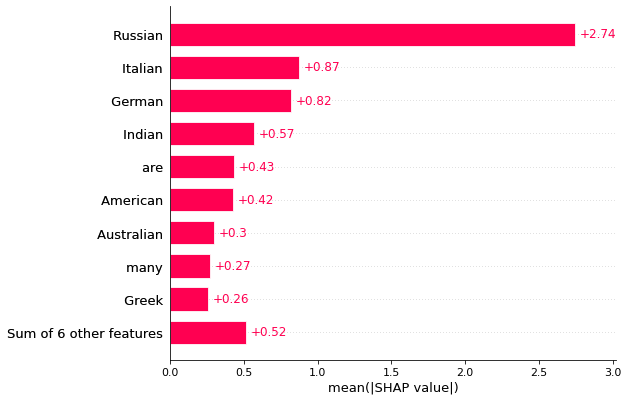

In [27]:
shap.plots.bar(shap_values[...,"vodka"])